# Check the correct working of the star cluster simulation code 

Use the star cluster simulation code in the module `agabpylib.simulation.starclusters` and check that it produces reasonable results.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u

from scipy.stats import norm

from agabpylib.simulation.starclusters.cluster import StarCluster, StarAPs
from agabpylib.simulation.imf import MultiPartPowerLaw as mppl
from agabpylib.simulation.starclusters.spacedistributions import PlummerSphere, ConstantDensitySphere
from agabpylib.simulation.starclusters.kinematics import LinearVelocityField
from agabpylib.simulation.starclusters.observables import GaiaSurvey
from agabpylib.plotting.plotstyles import useagab, apply_tufte

## Simulate the cluster

The next code block generates a simulated cluster according to the various input parameters

In [3]:
# Kroupa type IMF
imf = mppl(np.array([0.3,1.3,2.3]), np.array([0.1,0.5]))

# Astrophysical parameters of the cluster stars
age = 1200*u.Myr
isodir = "/home/brown/Stars/Modelgrids"
feh = 0.0
afeh = 0.0
vvcrit = 0.0

# Number of stars and core radius for Plummer distribution
nstars = 100
a = 6*u.pc

# Kinematic parameters
v=np.array([0,0,0])*u.km/u.s
s=np.array([0.0,0.0,0.0])*u.km/u.s
omega = np.array([0.05,0.05,0.05])*u.km/u.s/u.pc
kappa = 0.0*u.km/u.s/u.pc

aps = StarAPs(age, feh, afeh, vvcrit, isodir, imf, iso="mist")
pos = PlummerSphere(a)
#pos = ConstantDensitySphere(a)
kin = LinearVelocityField(v, s, omega, kappa)

distance_c = 45.0*u.pc
ra_c = 60.5*u.deg
dec_c = 15.9*u.deg
obs_interval = 22
survey = GaiaSurvey(obs_interval, distance_c, ra_c, dec_c)

cluster = StarCluster(nstars, aps, pos, kin, survey)

Reading in: /home/brown/Stars/Modelgrids/MIST_v1.2_vvcrit0.0_UBVRIplus/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_UBVRIplus.iso.cmd


UnitConversionError: Can only apply 'add' function to quantities with compatible dimensions

In [4]:
print(cluster.getinfo())

Simulated cluster parameters
Number of stars: 100

Astrophysical parameters
------------------------
Isochrone models: mist
Age, log(Age) specified: 1200.0 Myr, 9.079181246047625
log(Age) loaded: 9.100000000000001
[M/H]: 0.0
[alpha/Fe]: 0.0
[v/vcrit]: 0.0
Isochrone file: /home/brown/Stars/Modelgrids/MIST_v1.2_vvcrit0.0_UBVRIplus/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_UBVRIplus.iso.cmd

Initial Mass Function
---------------------
Multi-part powerlaw: slopes [0.3 1.3 2.3]; masses of break-points [0.1 0.5]

Space distribution
------------------
Plummer density distribution with core radius 6.0 pc

Kinematics
------------------
Linear velocity field:
 v = [0. 0. 0.] km / s
 s = [0. 0. 0.] km / s
 omega = [0.05 0.05 0.05] km / (pc s)
 kappa = 0.0 km / (pc s)



In [77]:
print(cluster.getmeta())

{'timestamp': '2019-09-07-16:05:49', 'n_stars': 100, 'ID': 'Simulated_cluster', 'age': <Quantity 1200. Myr>, 'logage': 9.079181246047625, 'logageloaded': 9.100000000000001, 'metallicity': 0.0, 'alpha_over_fe': 0.0, 'vvcrit': 0.0, 'stellarmodels': 'mist', 'isochronefile': '/home/brown/Stars/Modelgrids/MIST_v1.2_vvcrit0.0_UBVRIplus/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_UBVRIplus.iso.cmd', 'IMF': 'Multi-part powerlaw', 'IMF_slopes': array([0.3, 1.3, 2.3]), 'IMF_break_points': array([0.1, 0.5]), 'space_distribution': 'uniform density sphere', 'space_distribution_radius': <Quantity 6. pc>, 'kinematics': 'Linear velocity field', 'mean_velocity': <Quantity [0., 0., 0.] km / s>, 'velocity_dispersion': <Quantity [0., 0., 0.] km / s>, 'rotation_rate': <Quantity [0.05, 0.  , 0.  ] km / (pc s)>, 'expansion_rate': <Quantity 0. km / (pc s)>}


In [78]:
cluster.star_table[0:10].show_in_notebook()

idx,source_id,initial_mass,mass,log_L,log_Teff,log_g,Gabs,Gabs_BPb,Gabs_BPf,Gabs_RP,Vabs,Iabs,x,y,z,v_x,v_y,v_z
,,solMass,solMass,,,,,,,,,,pc,pc,pc,km / s,km / s,km / s
0,0,1.633083797854659,1.6326373711251518,1.0045780594062181,3.860894858191909,4.044675634595763,2.1291188029839545,2.269846877381024,2.2811907932467106,1.8878422935604084,2.1797475096369023,1.8425940003388355,-1.7344854222994948,2.4868872357184006,-0.5713641102666912,0.0,0.02856820551333456,0.12434436178592004
1,1,0.10473268191447406,0.10473243977353158,-2.9614221294933674,3.4635329374922463,5.225012466037701,13.645923748807533,15.825838106214796,15.86884694828168,12.322219336338254,15.611406153139372,12.053085112133587,-3.0387365021540966,-2.7174306986813397,3.450546734798828,0.0,-0.17252733673994142,-0.13587153493406698
2,2,0.2020724246908666,0.20207183495563819,-2.31749755195428,3.509552019036831,5.053092623338255,11.534027824155508,12.968593818626408,13.012054533337414,10.384804164556408,12.74451341361209,10.109951321655712,1.8328781597270332,-0.2496628071897972,0.8757617207530548,0.0,-0.043788086037652746,-0.01248314035948986
3,3,0.14839850733640808,0.14839811267372277,-2.5823998986538497,3.493878955642889,5.120810148481127,12.353242018201536,14.007001435421499,14.05014776756651,11.143027514504796,13.785754689931883,10.861093014324204,-0.2953590875102553,-2.2054449881577236,1.264319299553528,0.0,-0.0632159649776764,-0.11027224940788619
4,4,0.8931487123545141,0.8931263996697408,-0.31823319472171785,3.7280849194939263,4.573854673715589,5.456120807521615,5.844781695977889,5.877693712267129,4.917959217728579,5.641603608472646,4.828867146719323,0.5989925254998877,1.0902654108881948,0.6159159633314919,0.0,-0.030795798166574597,0.05451327054440974
5,5,0.28652140503001383,0.28652046851144874,-2.02228056003616,3.52997427304858,4.990744357631958,10.627357093591227,11.866783358777637,11.910671080564759,9.546464590718964,11.641375201422028,9.286264009504995,0.2764883669834717,0.6745987204693795,-4.6385762000840405,0.0,0.23192881000420204,0.03372993602346898
6,6,1.693078776389469,1.6925467552371254,1.0833036537238965,3.8606490955541206,3.980618443927755,1.927632281909322,2.06792272848463,2.079475218377256,1.6872614257396956,1.9776934765991068,1.6426348526609407,-2.4063456318813445,0.5331095098015125,4.674789474393589,0.0,-0.23373947371967946,0.026655475490075627
7,7,0.796580432536139,0.796566948442059,-0.5725381450337462,3.6876615823090213,4.613773245190921,6.183878029093658,6.669686735710793,6.709745438206457,5.557062138931334,6.447616130041184,5.455910282846212,3.328379124609118,3.443312253011097,0.18850050122034445,0.0,-0.009425025061017223,0.17216561265055486
8,8,0.2729221470804487,0.27292127108387154,-2.065383295941946,3.5267271154500697,4.999322364140697,10.758883775621698,12.023755151911416,12.067572011018301,9.667940045035515,11.798365421714694,9.405042359613887,0.5249212323244993,1.1960435531795472,-3.9578332626663153,0.0,0.19789166313331577,0.059802177658977364


In [79]:
cluster.star_table.info

<QTable length=100>
    name      dtype    unit   class  
------------ ------- ------- --------
   source_id   int64           Column
initial_mass float64 solMass Quantity
        mass float64 solMass Quantity
       log_L float64           Column
    log_Teff float64           Column
       log_g float64           Column
        Gabs float64           Column
    Gabs_BPb float64           Column
    Gabs_BPf float64           Column
     Gabs_RP float64           Column
        Vabs float64           Column
        Iabs float64           Column
           x float64      pc Quantity
           y float64      pc Quantity
           z float64      pc Quantity
         v_x float64  km / s Quantity
         v_y float64  km / s Quantity
         v_z float64  km / s Quantity

## Space distribution of stars

Check that the spatial distribution of the stars in the cluster is statistically correct.

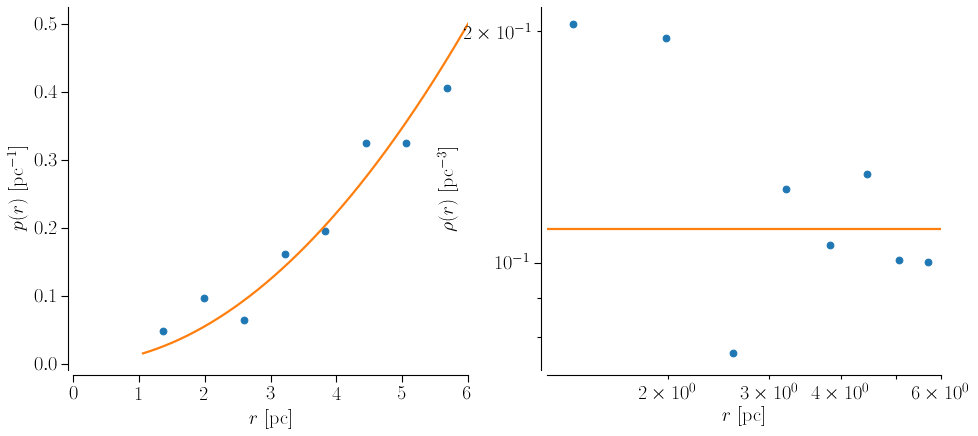

In [80]:
r = np.sqrt(cluster.star_table['x']**2 + cluster.star_table['y']**2 + cluster.star_table['z']**2)
rmaxplot = 0.0
if isinstance(pos, PlummerSphere):
    fd = lambda x : 3/(4*np.pi*a.value**3)*(1+(x/a.value)**2)**(-5/2)
    fn = lambda x : 4*np.pi*x**2*fd(x)
    rplotmax = 5*a.value
elif isinstance(pos, ConstantDensitySphere):
    fd = lambda x : np.repeat(3/(4*np.pi*a.value**3), x.size)
    fn = lambda x : 4*np.pi*x**2*fd(x)
    rplotmax = a.value
else:
    pass
    
useagab(usetex=False, fontfam='sans', sroncolours=False)

fig, (axA, axB) = plt.subplots(1, 2, figsize=(14,6))
apply_tufte(axA)
apply_tufte(axB)

rr = np.linspace(r.min().value,rplotmax,1000)
h, bins = np.histogram(r.value, bins='auto', density=False)
dbin = (bins[1:]-bins[0:-1])
xbin = dbin/2 +  bins[0:-1]

axA.plot(xbin, h/nstars/dbin, 'o')
axA.plot(rr, fn(rr))
axA.set_xlim(0,rplotmax)
axA.set_xlabel(r'$r$ [pc]')
axA.set_ylabel(r'$p(r)$ [pc$^{-1}$]')

dens = h/(4*np.pi/3*(bins[1:]**3-bins[0:-1]**3))
axB.loglog(xbin, dens, 'o')
axB.loglog(rr, nstars*fd(rr))
axB.set_xlim(0.9*xbin.min(),rplotmax)
axB.set_xlabel(r'$r$ [pc]')
axB.set_ylabel(r'$\rho(r)$ [pc$^{-3}$]')

plt.show()

## Initial mass function

Check that the initial mass distribution follows the requested IMF.

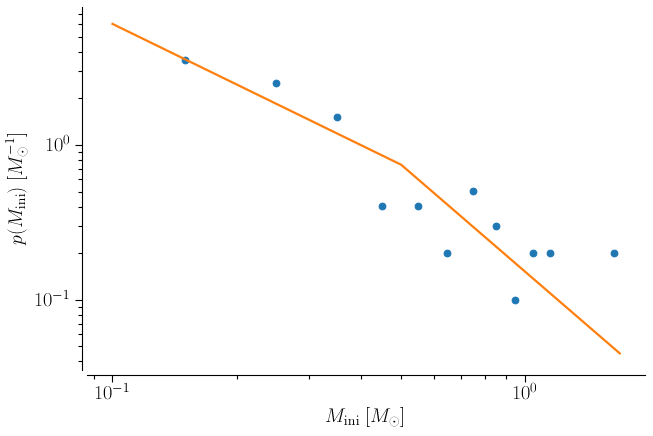

In [81]:
fig, aximf = plt.subplots(1, 1, figsize=(9,6))
apply_tufte(aximf)

min_mass = cluster.star_table['initial_mass'].min().value
max_mass = cluster.star_table['initial_mass'].max().value
mm = np.linspace(min_mass, max_mass, 1000)
h_imf, bins_imf = np.histogram(cluster.star_table['initial_mass'].value, bins='auto', density=True)
dbin_imf = (bins_imf[1:]-bins_imf[0:-1])
xbin_imf = dbin_imf/2 +  bins_imf[0:-1]

aximf.loglog(xbin_imf, h_imf, 'o')
aximf.loglog(mm, np.exp(imf.lnpdf(mm, min_mass, max_mass)))
aximf.set_xlabel(r'$M_\mathrm{ini}$ [$M_\odot$]')
aximf.set_ylabel(r'$p(M_\mathrm{ini})$ [$M_\odot^{-1}$]')

plt.show()

## Cluster colour-magnitude diagram

Check that the CMD looks reasonable

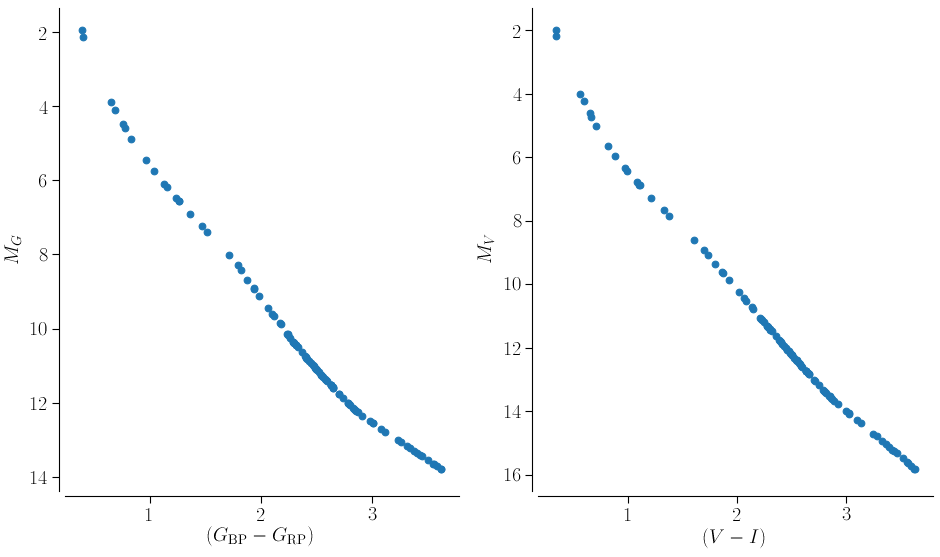

In [82]:
fig, (axbprp, axvmini) = plt.subplots(1, 2, figsize=(14,8))
apply_tufte(axbprp)
apply_tufte(axvmini)

axbprp.plot(cluster.star_table['Gabs_BPf']-cluster.star_table['Gabs_RP'], cluster.star_table['Gabs'], 'o')
axbprp.invert_yaxis()
axbprp.set_xlabel(r'$(G_\mathrm{BP}-G_\mathrm{RP})$')
axbprp.set_ylabel(r'$M_G$')

axvmini.plot(cluster.star_table['Vabs']-cluster.star_table['Iabs'], cluster.star_table['Vabs'], 'o')
axvmini.invert_yaxis()
axvmini.set_xlabel(r'$(V-I)$')
axvmini.set_ylabel(r'$M_V$')

plt.show()

## Kinematics

Inspect the simulated knematics for correctness.

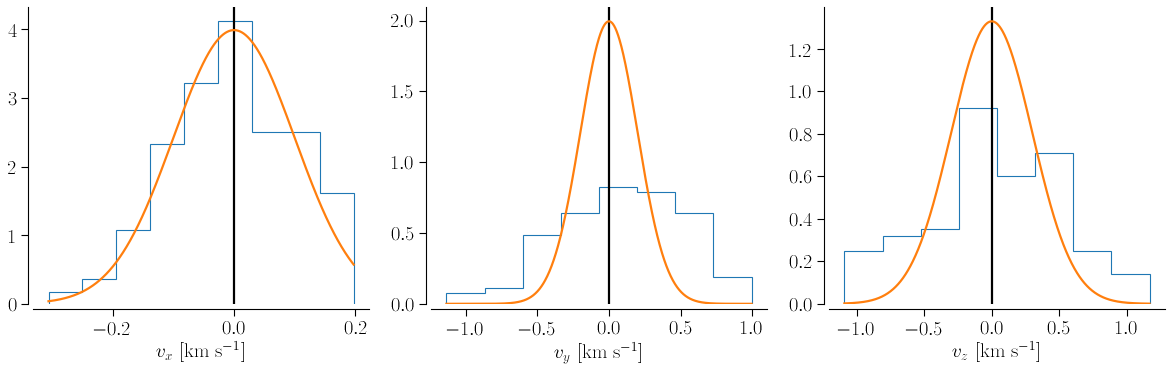

In [107]:
fig, (axvx, axvy, axvz) = plt.subplots(1, 3, figsize=(15,5))
apply_tufte(axvx)
apply_tufte(axvy)
apply_tufte(axvz)

axvx.hist(cluster.star_table['v_x'].value, bins='auto', histtype='step', density=True)
axvx.axvline(x=cluster.getmeta()['mean_velocity'][0].value, color='k')
xx = np.linspace(cluster.star_table['v_x'].min(), cluster.star_table['v_x'].max(), 1000)
axvx.plot(xx, norm.pdf(xx, loc=cluster.getmeta()['mean_velocity'][0], 
          scale=cluster.getmeta()['velocity_dispersion'][0]))
axvx.set_xlabel(r'$v_x$ [km s$^{-1}$]')

axvy.hist(cluster.star_table['v_y'].value, bins='auto', histtype='step', density=True)
axvy.axvline(x=cluster.getmeta()['mean_velocity'][1].value, color='k')
xx = np.linspace(cluster.star_table['v_y'].min(), cluster.star_table['v_y'].max(), 1000)
axvy.plot(xx, norm.pdf(xx, loc=cluster.getmeta()['mean_velocity'][1], 
          scale=cluster.getmeta()['velocity_dispersion'][1]))
axvy.set_xlabel(r'$v_y$ [km s$^{-1}$]')

axvz.hist(cluster.star_table['v_z'].value, bins='auto', histtype='step', density=True)
axvz.axvline(x=cluster.getmeta()['mean_velocity'][2].value, color='k')
xx = np.linspace(cluster.star_table['v_z'].min(), cluster.star_table['v_z'].max(), 1000)
axvz.plot(xx, norm.pdf(xx, loc=cluster.getmeta()['mean_velocity'][2], 
          scale=cluster.getmeta()['velocity_dispersion'][2]))
axvz.set_xlabel(r'$v_z$ [km s$^{-1}$]')

plt.tight_layout()

plt.show()

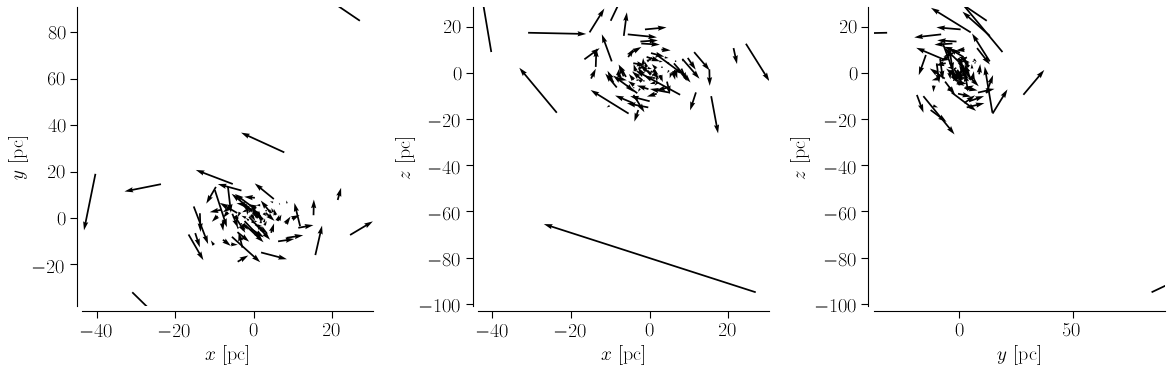

In [111]:
fig, (axxyq, axxzq, axyzq) = plt.subplots(1, 3, figsize=(15,5))
apply_tufte(axxyq)
apply_tufte(axxzq)
apply_tufte(axyzq)

axxyq.quiver(cluster.star_table['x'].value, cluster.star_table['y'].value, cluster.star_table['v_x'].value, 
             cluster.star_table['v_y'].value)
axxyq.set_xlabel(r'$x$ [pc]')
axxyq.set_ylabel(r'$y$ [pc]')

axxzq.quiver(cluster.star_table['x'].value, cluster.star_table['z'].value, cluster.star_table['v_x'].value, 
             cluster.star_table['v_z'].value)
axxzq.set_xlabel(r'$x$ [pc]')
axxzq.set_ylabel(r'$z$ [pc]')

axyzq.quiver(cluster.star_table['y'].value, cluster.star_table['z'].value, cluster.star_table['v_y'].value, 
             cluster.star_table['v_z'].value)
axyzq.set_xlabel(r'$y$ [pc]')
axyzq.set_ylabel(r'$z$ [pc]')

plt.tight_layout()

plt.show()